# Exploración: solvente de reacción

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from src.config import chemical_inventory_path, raw_data_path
from src import constants as ctes
from src import plot_utils

In [2]:
%cd ../..

/home/belu/VS Workplace/licentiate-thesis-repo


In [3]:
import src.data.notebook_utils as utils

df = utils.read_data(raw_data_path, binary_cristal_score=False)
columns = utils.get_columns(df.columns, as_list=False)

/home/belu/VS Workplace/licentiate-thesis-repo/src/data/notebook_utils.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['_out_crystalscore'] = df['_out_crystalscore'].astype(int)


In [4]:
len(df)

6096

In [5]:
organic_key = False
binary_cristal_score = False

In [6]:
df = pd.read_csv(raw_data_path, header=0, low_memory=False)

df = df.fillna(0)

chemical_info = utils.read_chemical_info()

chemical_info[['Chemical Abbreviation', 'InChI Key (ID)']].dropna()
df = df.set_index('_rxn_organic-inchikey').join(chemical_info.set_index('InChI Key (ID)'), 
                                                how='inner').reset_index().rename({'index': '_rxn_organic-inchikey'}, 
                                                axis='columns')
#selected_columns = rings_feat+columns_arbitrary_decision+continous_feat+rxn_feat+target+['Chemical Abbreviation']

selected_columns = utils.get_columns(df.columns)

if(organic_key): 
    selected_columns += ["_rxn_organic-inchikey"]

df = df.query("_out_crystalscore > 0")
df['_out_crystalscore'] = df['_out_crystalscore'].astype(int)

if binary_cristal_score:
    df['_out_crystalscore'] = (df['_out_crystalscore'] == 4).astype(int)

selected_columns+=['_out_crystalscore', '_raw_reagent_0_chemicals_0_InChIKey', 'Chemical Abbreviation']

In [7]:
df = df[selected_columns]

### Cantidad de datos por organoaminas-solvente

In [8]:
df['solvent'] = df.apply(lambda row: ctes.INCHI_TO_CHEMNAME[row['_raw_reagent_0_chemicals_0_InChIKey']], axis=1)

In [9]:
df['solvent'].unique()

array(['Dimethylformamide', 'Dimethyl sulfoxide', 'Gamma-Butyrolactone',
       '0'], dtype=object)

In [10]:
df.groupby(by='solvent')['Chemical Abbreviation'].value_counts()

solvent              Chemical Abbreviation                
0                    IPentylammoniumIodide                       8
Dimethyl sulfoxide   PyrrolidiniumIodide                       384
                     Benzenediaminedihydroiodide                96
                     CyclohexylammoniumIodide                   96
                     PiperidiniumIodide                         96
                     PyridiniumIodide                           96
                     nOctylammoniumIodide                       96
Dimethylformamide    Me2NH2I                                   303
                     Propane13diammoniumIodide                 177
                     2Pyrrolidin1ium1ylethylammoniumiodide      96
                     4FluoroBenzylammoniumIodide                96
                     Butane14diammoniumIodide                   96
                     MorpholiniumIodide                         96
                     NNDimethylethane12diammoniumiodide         96
   

In [12]:
solvents = df.solvent.unique()
set_amines_per_solvet = [set(df[df.solvent == sol] \
                         ['Chemical Abbreviation'] \
                         .unique()) for sol in solvents]

In [13]:
len(set_amines_per_solvet[2])

29

There is almost any amine used in different solvents. We cannot train a model for multisolvent conditions.

In [14]:
for set_in in range(0,3):
    for other_set in range(set_in+1, 3):
        print(set_in, other_set,set_amines_per_solvet[set_in].intersection(set_amines_per_solvet[other_set]))

0 1 set()
0 2 {'Me2NH2I'}
1 2 set()


In [15]:
df.groupby(by='solvent')['_out_crystalscore'].value_counts()

solvent              _out_crystalscore
0                    1                       5
                     2                       3
Dimethyl sulfoxide   1                     531
                     2                     213
                     4                      65
                     3                      55
Dimethylformamide    1                     597
                     4                     214
                     3                     171
                     2                     114
Gamma-Butyrolactone  1                    3435
                     4                    1568
                     2                    1378
                     3                     893
Name: _out_crystalscore, dtype: int64

In [16]:
def plot_for_amine(amine,ax):
    return sns.countplot(y="Chemical Abbreviation", data=df, orient='h', hue='_out_crystalscore',
                      order = df[df.solvent == amine]["Chemical Abbreviation"].value_counts().index, ax=ax)

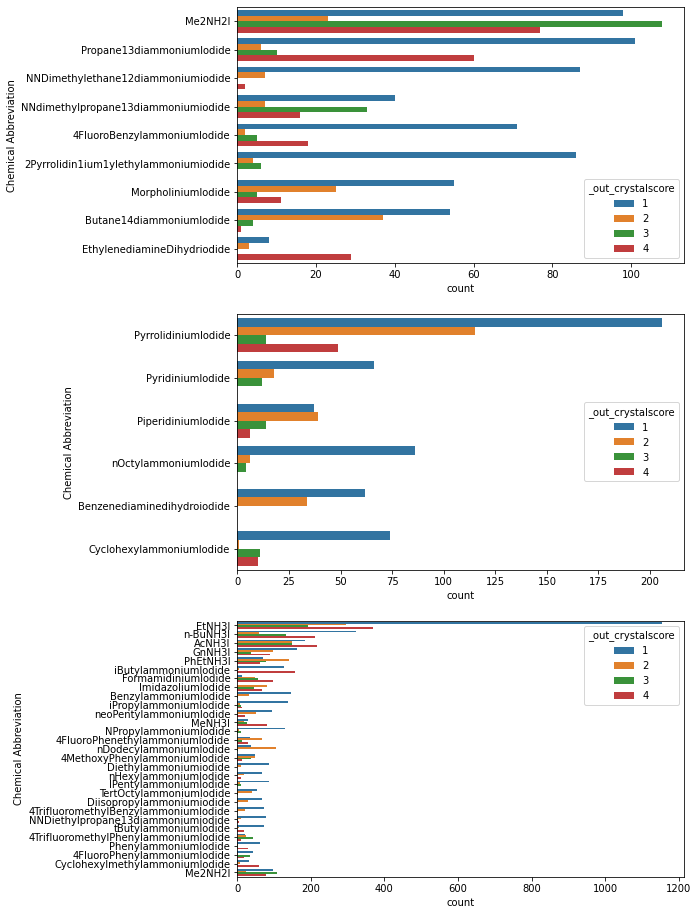

In [18]:
fig, axes = plt.subplots(3, 1, figsize=(8,16))

for ax, amine in zip(axes.flatten(), solvents[:-1]):
    plot_for_amine(amine,ax)

**Possible experiments: solvent influence?**
- model A: we train for a high volume solvent and test it on experimental solvent (less data available),
- model B: dismiss solvent information, train test in general (tes from exp solvent)
- model C: we train a model with solvent as a feature

1. Random sample aggregated by solvent type and binary crystal score
2. Model A:
    - Is data from one solvent helping other? Maybe because of reagents concentrations.
    Compared to shuffle? Compared to a sample from train solvent?
        - Expected result: a better performance on train solvent dataset since
        the model has learnt specific patterns about that solvent. If they are similar,
        it means no particular info was obtained from splitting datasets.